# <font  color = "#0093AF">TROSY effects</font>

<a href="https://githubtocolab.com/alsinmr/SLEEPY_tutorial/blob/main/ColabNotebooks/Chapter2/Ch2_TROSY.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>

TROSY (Transverse Relaxation Optimized SpectroscopY)$^1$ is an important experiment in solution-NMR, which takes advantage of different relaxation rates of doublets coming from the H–N J-coupling in the $^1$H or $^{15}$N dimensions. 

The effect arises from the constructive or deconstructive effects of motion on relaxation due to the $^{15}$N chemical shift anisotropy (or $^1$H CSA) and the H–N dipole coupling. For one peak of the doublet, relaxation from the CSA and dipole anisotropies is constructive, but on the other peak it is destructive, resulting in one fast-relaxing peak and one slow-relaxing peak.

Here, we will assume the tensors for these two interactions are parallel. This is not entirely accurate (being tilted from each other by about 23$^\circ$), but it allows us to average the couplings to zero, mimicking tumbling in solution, with a simple, tetrahedral hopping motion.

[1] K. Pervushin, R. Riek, G. Wider, K. Wüthrich. [*Proc. Natl. Acad. Sci. USA.*](https://doi.org/10.1073/pnas.94.23.12366) **1997**, 94, 12366 

## Setup

In [0]:
# SETUP SLEEPY
import sys
if 'google.colab' in sys.modules:
  !pip install sleepy-nmr

In [2]:
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt

## Build the system

We need a 2-spin $^1$H–$^{15}$N system with dipole and CSA terms to yield relaxation, plus a $J$-coupling to separate the $^{15}$N resonance into peaks corresponding to the $^1$H$^\alpha$ and $^1$H$^\beta$ states. Since we start just observing transverse relaxation, we do not require a lab-frame calculation.

In [3]:
# By default, SLEEPY gives us powder average when including anisotropic terms.
# However, we don't need it for mimicking tumbling, 
# so we set it explicitly to a 1-element powder average
ex=sl.ExpSys(v0H=400,Nucs=['15N','1H'],vr=0,pwdavg='alpha0beta0')
delta=sl.Tools.dipole_coupling(.102,'1H','15N')
ex.set_inter('dipole',i0=0,i1=1,delta=delta)
ex.set_inter('CSA',i=0,delta=113)
ex.set_inter('J',i0=0,i1=1,J=92)

# Set up 4-site motion
L=sl.Tools.SetupTumbling(ex,tc=1e-9,q=1) #Defaults to the magic angle, which will average the couplings

## 1D spectrum

State-space reduction: 64->8


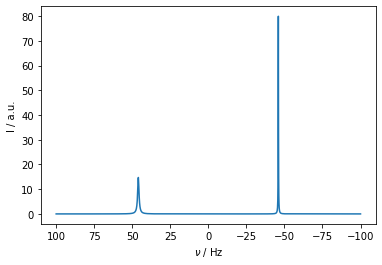

In [4]:
rho=sl.Rho('15Nx','15Np')
seq=L.Sequence(Dt=5e-3)

rho.DetProp(seq,n=10000)
_=rho.plot(FT=True)

We obtain two peaks, separated by the J-coupling, one being notably more intense and narrower than the other, where relaxation effects from the $^{15}$N CSA and H–N dipole coupling cancel. Note that since the CSA scales with field, the cancelation effect is also field dependent. We calculate the spectrum maximum as a function of field, and record the spectrum maximum to demonstrate.

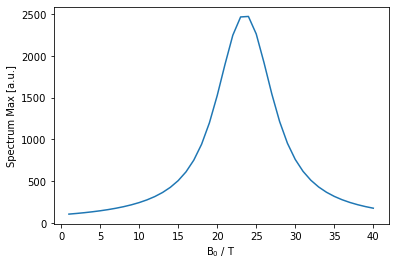

In [5]:
sl.Defaults['verbose']=False #Suppress output for loop
B0_0=np.linspace(1,40,40)
I=[]
for B0 in B0_0:
    ex=sl.ExpSys(B0=B0,Nucs=['15N','1H'],vr=0)
    ex.set_inter('dipole',i0=0,i1=1,delta=delta)
    ex.set_inter('CSA',i=0,delta=113)
    ex.set_inter('J',i0=0,i1=1,J=92)
    
    L=sl.Tools.SetupTumbling(ex,tc=1e-9,q=1)

    rho=sl.Rho('15Nx','15Np')
    seq=L.Sequence(Dt=5e-3)

    rho.DetProp(seq,n=10000)
    I.append(rho.FT[0].real.max())
ax=plt.subplots()[1]
ax.plot(B0_0,I)
ax.set_xlabel(r'B$_0$ / T')
_=ax.set_ylabel('Spectrum Max [a.u.]')

We see the max occuring at ~24 T, as predicted by Fernández and Wider (23.5 T).$^2$

[2] C. Fernández, G. Wider. [*Curr. Opin. Struct. Biol.*](https://doi.org/10.1016/j.sbi.2003.09.009). **2003**, 13, 570-580.

## With and without decoupling
We can also compare what happens to the spectrum without and with decoupling. We go a little ways away from the optimal field so that the smaller peak still has a reasonable intensity.

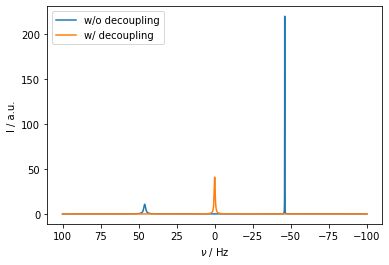

In [6]:
ex=sl.ExpSys(B0=15,Nucs=['15N','1H'],vr=0,pwdavg='alpha0beta0')
delta=sl.Tools.dipole_coupling(.102,'1H','15N')
ex.set_inter('dipole',i0=0,i1=1,delta=delta)
ex.set_inter('CSA',i=0,delta=113)
ex.set_inter('J',i0=0,i1=1,J=92)

# Set up 4-site motion
L=sl.Tools.SetupTumbling(ex,tc=1e-9,q=1)

rho=sl.Rho('15Nx','15Np')
seq=L.Sequence(Dt=5e-3)

rho.DetProp(seq,n=10000)
ax=rho.plot(FT=True)

seq.add_channel('1H',v1=500)

rho.clear()
rho.DetProp(seq,n=10000)
rho.plot(FT=True,ax=ax)
_=ax.legend(('w/o decoupling','w/ decoupling'))

The decoupled spectrum has significantly less intensity than the larger peak of the undecoupled spectrum, motivating the application of TROSY.

## Longitudinal effects from asymmetric relaxation

When measuring $T_1$ in solution NMR, one must take care to account for multiexponential $T_1$ relaxation. To obtain $T_1$ relaxation from exchange, we need to perform our calculations in the lab frame, so we set up a new `ExpSys` object (`ex` is constructed from `ex0` using the `SetupTumbling` function).

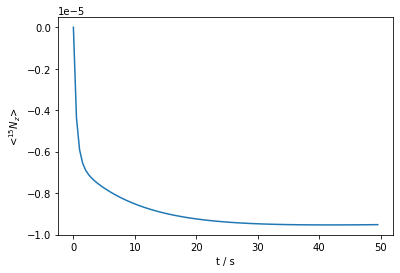

In [7]:
ex0=sl.ExpSys(v0H=1200,Nucs=['15N','1H'],vr=0,LF=True,pwdavg='alpha0beta90')
delta=sl.Tools.dipole_coupling(.102,'1H','15N')
ex0.set_inter('dipole',i0=0,i1=1,delta=delta)
ex0.set_inter('CSA',i=0,delta=113)
ex0.set_inter('J',i0=0,i1=1,J=92)

# Set up 4-site motion
L=sl.Tools.SetupTumbling(ex0,tc=1e-9,q=1) #Defaults to the magic angle, which will average the couplings
L.add_relax('DynamicThermal')

rho=sl.Rho('zero','15Nz')
seq=L.Sequence(Dt=.5)

rho.DetProp(seq,n=100)
_=rho.plot(axis='s')

We observe a strongly bi-exponential behavior, corresponding to relaxation of the $\hat{S}_z\hat{I}_\alpha$ and $\hat{S}_z\hat{I}_\beta$ states. We can saturate the $^1$H to recover monoexponential behavior. However, because this calculation is in the lab frame, we cannot apply RF-fields as easily. This is because the applied RF is not static in the lab frame, but rather oscillates as in the real experiment, complicating its application in simulation. SLEEPY has a special tool, `sl.LFrf`,  for adding cw-irradation in the lab frame. This class takes a sequence as argument for initialization (which is used to specify the field strength and nucleus), and returns a propagator, `U`, with the corresponding applied field. We do not currently support time-dependent sequences for lab-frame irradiation.

LF calculation: |██████████████████████████████| 100% complete
Completed


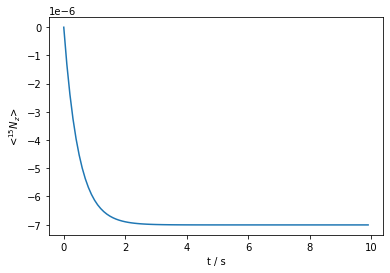

In [8]:
rho.clear()
seq=L.Sequence(Dt=.1).add_channel('1H',v1=500)
U=sl.LFrf(seq).U()
rho.DetProp(U,n=100)
_=rho.plot(axis='s')

The decay curve becomes monoexponential. Note the equilibrium's  absolute value is also slightly decreased, due to an unfavorable NOE condition at 1 ns for H–N NOE.